<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/chronoroot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChronoRoot　（未完）
訓練済みのモデルで根の解析を行うノートブック

## ライセンス
- ChronoRoot論文, Gaggion et al., 2021, GigaScience (https://academic.oup.com/gigascience/article/10/7/giab052/6324285)
    - CC-BY
- 公式レポジトリ（https://github.com/ngaggion/ChronoRoot）
    - GPLv3
- データセット（http://gigadb.org/dataset/100911）
    - GIGAdbの利用規約が定めるライセンス（http://gigadb.org/site/term; CC0相当）に準拠
- 本稿プログラムコード
    - **本章のコードは公式レポジトリのライセンスを継承してGPLv3となります。**

### メモ
python segmentFast.py imagePath --output_dir optionalSegPath --use_crf boolean --model ResUNetDS
- > 結果をchronorootで解析


## 環境構築

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/phenotyping_temp_assets/Test_ChronoRoot.zip ./
!unzip Test_ChronoRoot.zip

Archive:  Test_ChronoRoot.zip
   creating: Test_ChronoRoot/
   creating: Test_ChronoRoot/rpi14_2019-12-09_16-13/
   creating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-22_10-15-01_1.nii.gz  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-22_10-15-01_1.png  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-25_23-15-01_1.nii.gz  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-25_23-15-01_1.png  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-28_23-30-01_1.nii.gz  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-28_23-30-01_1.png  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-31_15-15-01_1.nii.gz  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-31_15-15-01_1.png  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2020-01-03_07-00-01_1.nii.gz  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2020-01-03_07-00-01_1.png

In [ ]:
!cp /content/drive/MyDrive/phenotyping_temp_assets/cr_resunetds.onnx ./

In [ ]:
# 公式レポジトリのクローニング
# !git clone https://github.com/ngaggion/ChronoRoot.git

# pydensecrfのインストール
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

# モデルチェックポイントファイルのダウンロード
# !gdown 1OSqvRXKay-0bsmQqtlmYnu_sp6-_I-eC
# !unzip modelWeights.zip

# テストデータセットのダウンロード
# !wget -O Test_ChronoRoot.zip https://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100911/LabeledDataset/Test_ChronoRoot.zip
# !unzip Test_ChronoRoot.zip

# 不要ファイルの削除
# !rm modelWeights.zip
# !rm Test_ChronoRoot.zip

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-aj1sc9z8
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-aj1sc9z8
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit dd070546eda51e21ab772ee6f14807c7f5b1548b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405486 sha256=f4d6a7bdf00376fdeea0639c7f7fe1424b3a63a9d6939a7de4bd3933960ea409
  Stored in directory: /tmp/pip-ephem-wheel-cache-jayp0a1m/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf


In [ ]:
def pad_image_to_multiple_of_32(img_path):
    # Read the grayscale image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Calculate the required padding for height and width
    pad_height = 32 - (img.shape[0] % 32) if img.shape[0] % 32 != 0 else 0
    pad_width = 32 - (img.shape[1] % 32) if img.shape[1] % 32 != 0 else 0

    # Pad the image
    padded_img = cv2.copyMakeBorder(img,
                                    0, pad_height,  # top, bottom padding
                                    0, pad_width,   # left, right padding
                                    cv2.BORDER_CONSTANT,
                                    value=0)  # 0 is for black in grayscale

    return padded_img

5
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)


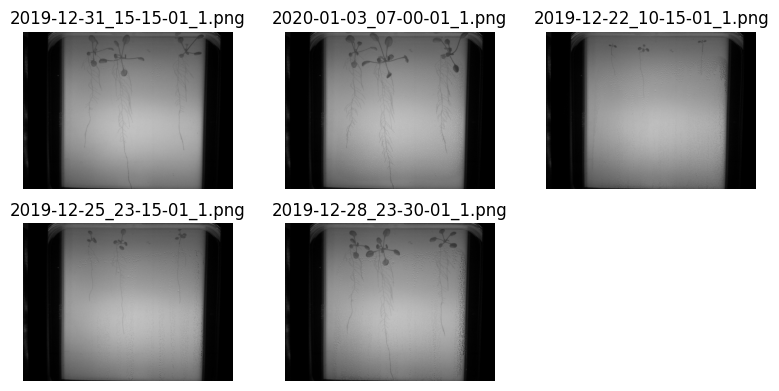

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

TEST_DIR = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"

# nii.gzはアノテーションファイルであるため、png拡張子の画像のみフィルタリングする
files = [x for x in os.listdir(TEST_DIR) if x.endswith(".png")]
print(len(files))  # 5枚

plt.figure(figsize=(8,4))
for i, file in enumerate(files):
    path = os.path.join(TEST_DIR, file)
    image = cv2.imread(path)
    print(image.shape)
    image = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
    plt.subplot(2,3,i+1)
    plt.title(file)
    plt.imshow(image)
    plt.axis("off")

plt.tight_layout()

In [ ]:
# 作者らの公式レポジトリのREADMEに従い、colaboratoryでsegmentFastやsegmentEnsembleを実行すると
# tensorflowのバージョン齟齬によりエラーがおきます。独自の環境で実行したい方は公式推奨のdockerイメージを利用してください。

In [ ]:
!pip install onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.5 MB/s eta 0:00:00


In [ ]:
import onnxruntime as ort

In [ ]:
# 気孔開閉判定モデルの読み込み
classifier_path = "/content/cr_resunetds.onnx"
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
ort_session = ort.InferenceSession(classifier_path, providers=providers)

# inputとoutputの名前を把握します。
input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

Input names: ['x:0']
Output names: ['pixel_wise_softmax/truediv:0']


In [ ]:
def pad_image_to_multiple_of(v, multipleOf=[8, 8], mode='symmetric'):
    padding = ((0, 0 if v.shape[0] % multipleOf[0] == 0 else multipleOf[0] - (v.shape[0] % multipleOf[0])),
               (0, 0 if v.shape[1] % multipleOf[1] == 0 else multipleOf[1] - (v.shape[1] % multipleOf[1])))
    return np.pad(v, padding, mode)

def preprocess(image):
    # assure dtype is float32
    image = image.astype(np.float32)/255.
    # 画像サイズが32の倍数になるようにpaddingします。
    image = pad_image_to_multiple_of(image, [32,32])
    return image


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
TEST_DIR = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"

# nii.gzはアノテーションファイルであるため、png拡張子の画像のみフィルタリングする
files = [x for x in os.listdir(TEST_DIR) if x.endswith(".png")]

# colab pro cpuで実行するとメモリエラー。gpu使ってみる？

for i, file in enumerate(files):
    path = os.path.join(TEST_DIR, file)
    image = cv2.imread(path, 0 )
    image = preprocess(image)
    print(image.shape)
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    prediction = ort_session.run(output_names, {"x:0": image})[0]
    print(prediction.shape)

    break

(2464, 3296)
(1, 2464, 3296, 2)


In [ ]:
# 0がcrfっ処理用っぽい
# https://github.com/ngaggion/ChronoRoot/blob/master/segmentFast.py

In [ ]:
import pydensecrf.densecrf as dcrf

def post_process(prediction):
    accum = np.zeros(prediction.shape[1:3])
    image = cv2.cvtColor((prediction[0,:,:,0]*255).astype('uint8'), cv2.COLOR_GRAY2RGB)
    image = np.ascontiguousarray(image)

    label_1 = np.transpose(prediction[0,:,:,:], (2,0,1))
    unary = -np.log(np.clip(label_1,1e-5,1.0))
    c, h, w = unary.shape
    unary = unary.transpose(0, 2, 1)
    unary = unary.reshape(2, -1)
    unary = np.ascontiguousarray(unary)

    denseCRF = dcrf.DenseCRF2D(w, h, 2)
    denseCRF.setUnaryEnergy(unary)
    denseCRF.addPairwiseBilateral(sxy=5, srgb=3, rgbim=image, compat=1)

    q = denseCRF.inference(1)
    crf_map = np.array(q).reshape(2, w, h).transpose(2, 1, 0)

    accum = 0.8 * accum + crf_map[:,:,1]
    return accum

accum = post_process(prediction)
_, outimg = cv2.threshold(accum, 0.5, 1.0, cv2.THRESH_BINARY)

In [ ]:
cv2.imwrite("raw.jpg",prediction[0,...,1]*255)

True

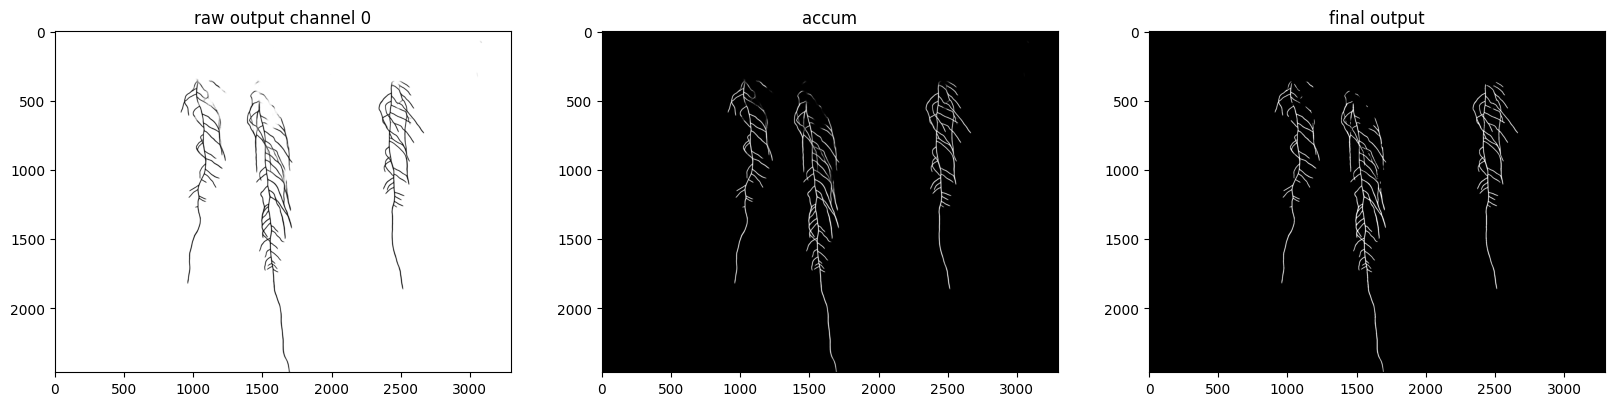

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.title("raw output channel 0")
plt.imshow(prediction[0,...,0], cmap="gray")

plt.subplot(1,3,2)
plt.title("accum")
plt.imshow(accum, cmap="gray")

plt.subplot(1,3,3)
plt.title("final output")
plt.imshow(outimg, cmap="gray")

In [ ]:
cv2.imwrite("crf.jpg", outimg*255)

True

In [ ]:
https://github.com/ngaggion/ChronoRoot/blob/master/segmentFast.py

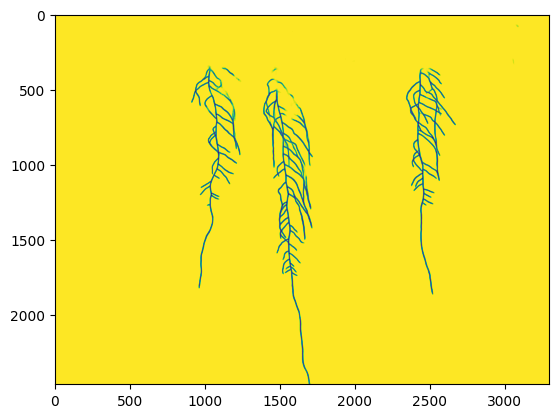

In [ ]:
plt.imshow(prediction[0,...,0])

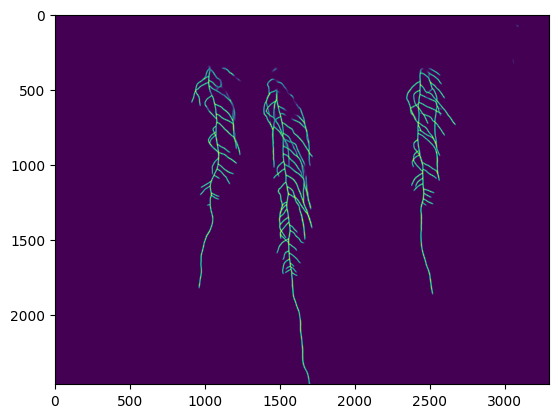

In [ ]:
plt.imshow(prediction[0,...,1])

In [ ]:
# post process with crf


1